In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_docs as tfdocs
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from utils import config

mpl.rcParams['figure.figsize'] = [35.0, 7.0]
HDFStore=pd.HDFStore


In [2]:
# loading data parameters
num_coefficients=int(config["coefficients"])
root_path=config["root_path"]
hw_results_path= config["hw_results_path"]

# training parameters
seed=int(config["seed"]) if "seed" in config.keys() else 42

dr=float(config["dropout"]) if "dropout" in config.keys() else 0.2
lr2=float(config["lr2"]) if "lr2" in config.keys() else 1e-3
lr1=float(config["lr1"]) if "lr1" in config.keys() else 1e-4
lr=float(config["lr"]) if "lr" in config.keys() else 8e-4

num_epochs=int(config["num_epochs"]) if "num_epochs" in config.keys() else 1000
num_features=int(config["features"]) if "features" in config.keys() else 4096
mini_batch_size=int(config["mini_batch_size"]) if "mini_batch_size" in config.keys() else 4

main_units=int(config["main_units"]) if "main_units" in config.keys() else 64
secondary_units=int(config["secondary_units"]) if "secondary_units" in config.keys() else 16
last_unit=int(config["last_unit"]) if "last_unit" in config.keys() else 8
lstm_units=int(config["lstm_units"]) if "lstm_units" in config.keys() else 64
num_classes=int(config["num_classes"]) if "num_classes" in config.keys() else 1


print_sample=False

In [3]:
#Load data from hdf5 file
rdo_root_path = path.join(root_path,hw_results_path)
h5file = path.join(rdo_root_path, "archimedean-")
h5filename = h5file + str(num_coefficients) + "-splits.h5"
print(h5filename)
hdf = HDFStore(h5filename)
hdf.keys()

/data/elekin/data/results/03-HANDWRITTING/archimedean-17-splits.h5


['/residues/train/features',
 '/residues/train/labels',
 '/residues/test/features',
 '/residues/test/labels']

In [1]:
#Load and scale timeseries between 0 and 1
x_train = hdf["/residues/train/features"].values.astype('float32')
y_train = hdf["/residues/train/labels"].values.astype('int8').reshape(-1,1)
x_test = hdf["/residues/test/features"].values.astype('float32')
y_test = hdf["/residues/test/labels"].values.astype('int8').reshape(-1,1)
hdf.close()

NameError: name 'hdf' is not defined

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(2).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(2).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

if print_sample:
    for feat, targ in test_dataset.take(10):
        print ('Features test: {}, Target: {}'.format(feat, targ))

    for feat, targ in test_dataset.take(10):
        print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))
test_dataset

9 train batches and 5 test batches of 4 mini batch size and 2 steps per epoch


<CacheDataset shapes: ((None, 4096), (None, 1)), types: (tf.float32, tf.int8)>

## FCNN ARCHITECTURE ANALISYS

Some training helpers functions

In [6]:
# #Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=1e-3,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=1e-4,
  patience=200)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        earlystop_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-5),
        #tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, train_dataset, test_dataset, name, optimizer=None, max_epochs=1000):
    tf.keras.backend.clear_session()# avoid clutter from old models and layers, especially when memory is limited
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    tf.random.set_seed(seed) # establecemos la semilla para tensorflow
    history = model.fit(train_dataset, 
                        use_multiprocessing=True, 
                        validation_data=test_dataset, epochs=max_epochs, 
                        callbacks=get_callbacks(name),
                        verbose=0, shuffle=True)
    return history

# Many models train better if you gradually reduce the learning rate during training. 
# Use optimizers.schedules to reduce the learning rate over time:
def get_optimizer(steps_per_epoch=1, lr=1e-4, multiplier=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(lr,
                                                                 decay_steps=steps_per_epoch*multiplier,
                                                                 decay_rate=1,
                                                                 staircase=False)
    return tf.keras.optimizers.Adam(lr_schedule)

In [7]:
size_histories = {}

In [8]:
# for key in size_histories:
#     plt.plot(size_histories[key].history["accuracy"])
#     plt.legend[]

In [9]:
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)])

size_histories['fcnn/tiny'] = compile_and_fit(tiny, train_dataset, 
                                              test_dataset,
                                              "fcnn/tiny", 
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 262,273
Trainable params: 262,273
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5152,  loss:1.1298,  val_accuracy:0.5882,  val_loss:1.0558,  
....................................................................................................
Epoch: 100, accuracy:0.7576,  loss:0.5244,  val_accuracy:0.5294,  val_loss:0.7053,  
....................................................................................................
Epoch: 200, accuracy:0.7576,  loss:0.4551,  val_accuracy:0.5294,  val_loss:0.6997,  
.
#######################Evaluation#####################

In [10]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, train_dataset, 
                                              test_dataset,'fcnn/small',
#                                               optimizer=get_optimizer(),
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9),
                                              max_epochs=num_epochs)

print("\n#######################Evaluation###########################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/small'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/small'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 263,793
Trainable params: 263,793
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5152,  loss:0.8303,  val_accuracy:0.5882,  val_loss:0.7719,  
....................................................................................................
Epoch: 100, accuracy:0.7273,  loss:0.4109,  val_accuracy:0.4118,  val_loss:0.9189,  
....................................................................................................
Epoch: 20

In [11]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)),  
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, train_dataset, 
                                              test_dataset, "fcnn/large",
                                              optimizer=tf.keras.optimizers.Adam(lr), 
#                                               optimizer=get_optimizer(), 
                                              max_epochs=num_epochs)

print("Evaluation")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/large'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 200       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 268,137
Trainable params: 268,137
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4848,  loss:0.7605,  val_accuracy:0.5882,  val_loss:0.7206,  
................................

(0.0, 1.5)

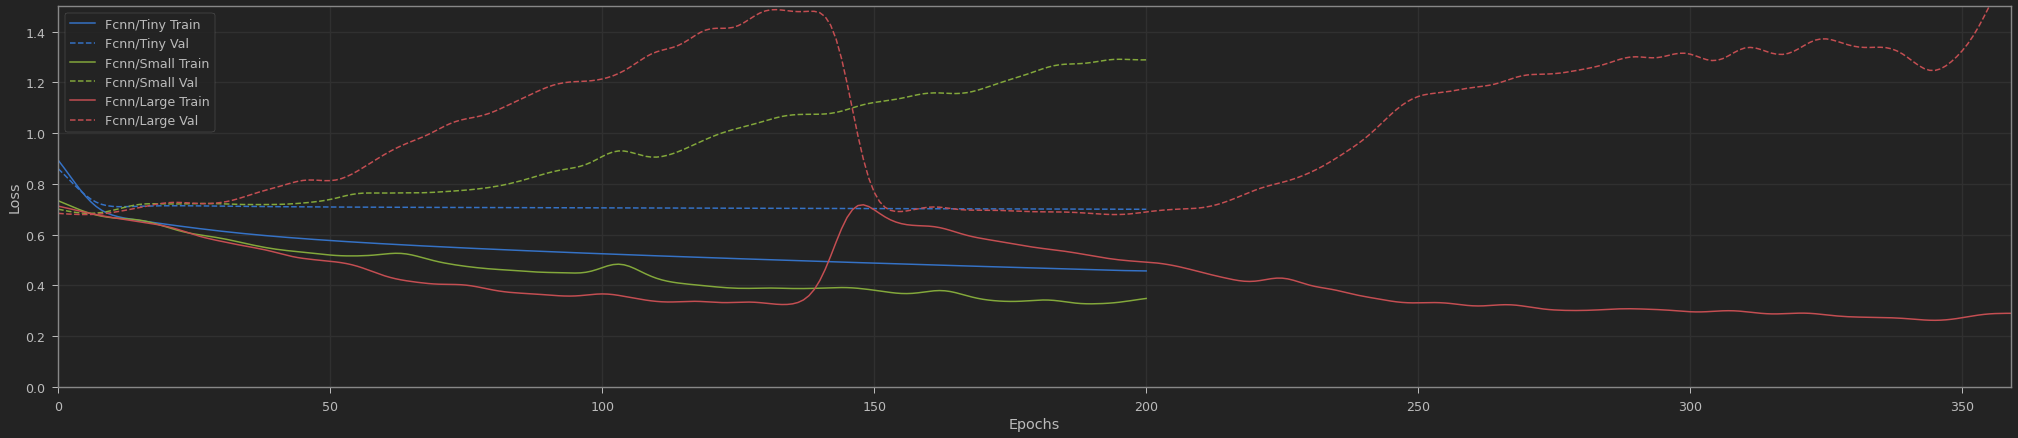

In [12]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0., 1.5])

(0.0, 1.1)

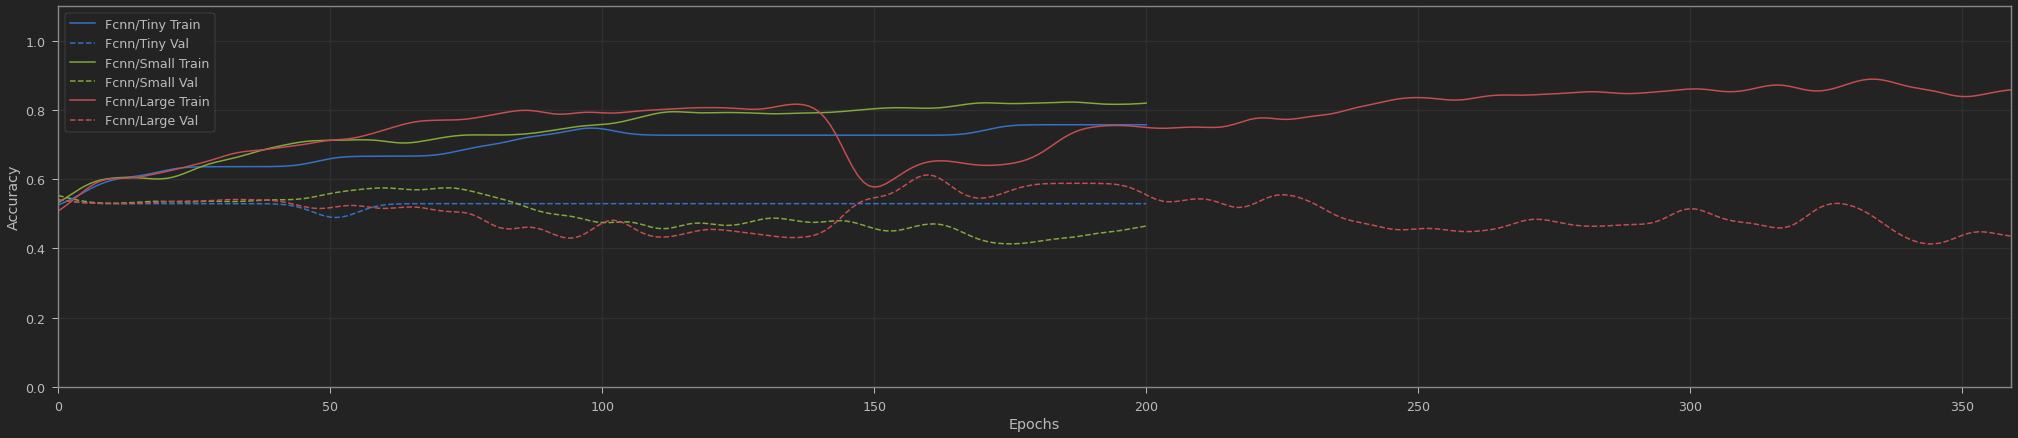

In [13]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
plt.ylim([0., 1.1])

Text(0.5, 0, 'Epochs [Log Scale]')

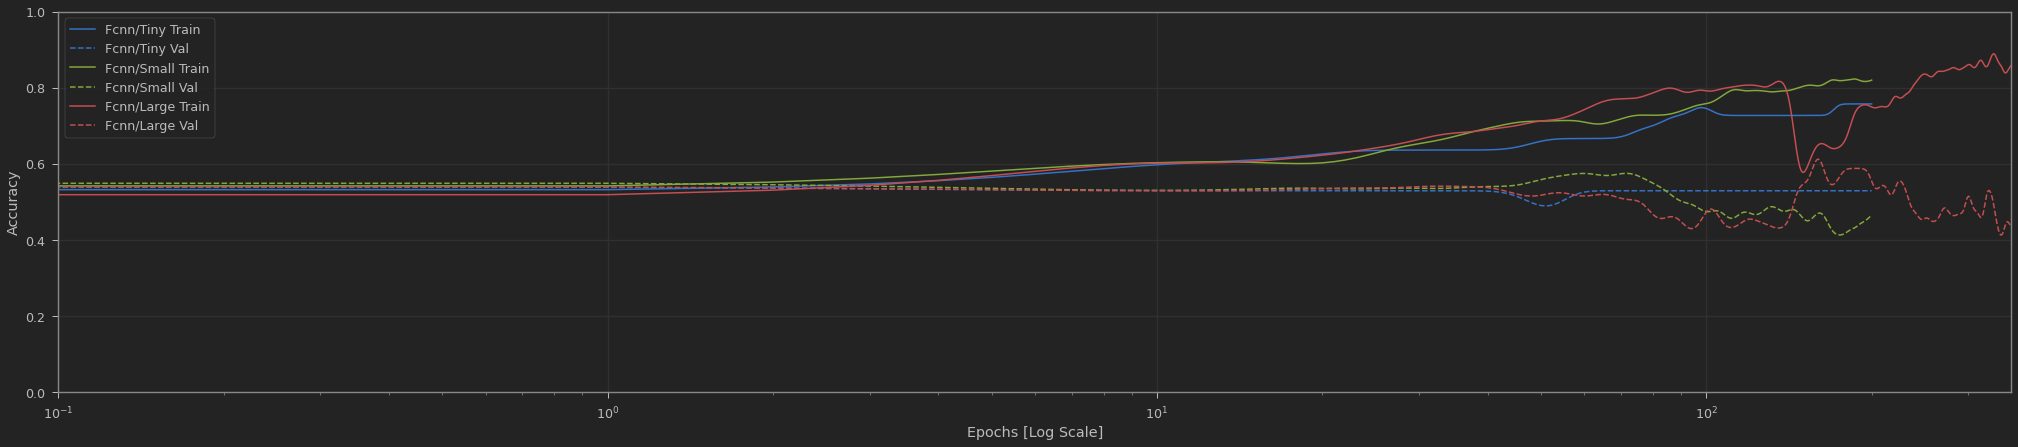

In [14]:
plotter_acc.plot(size_histories)
a = plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.ylim([0., 1.])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

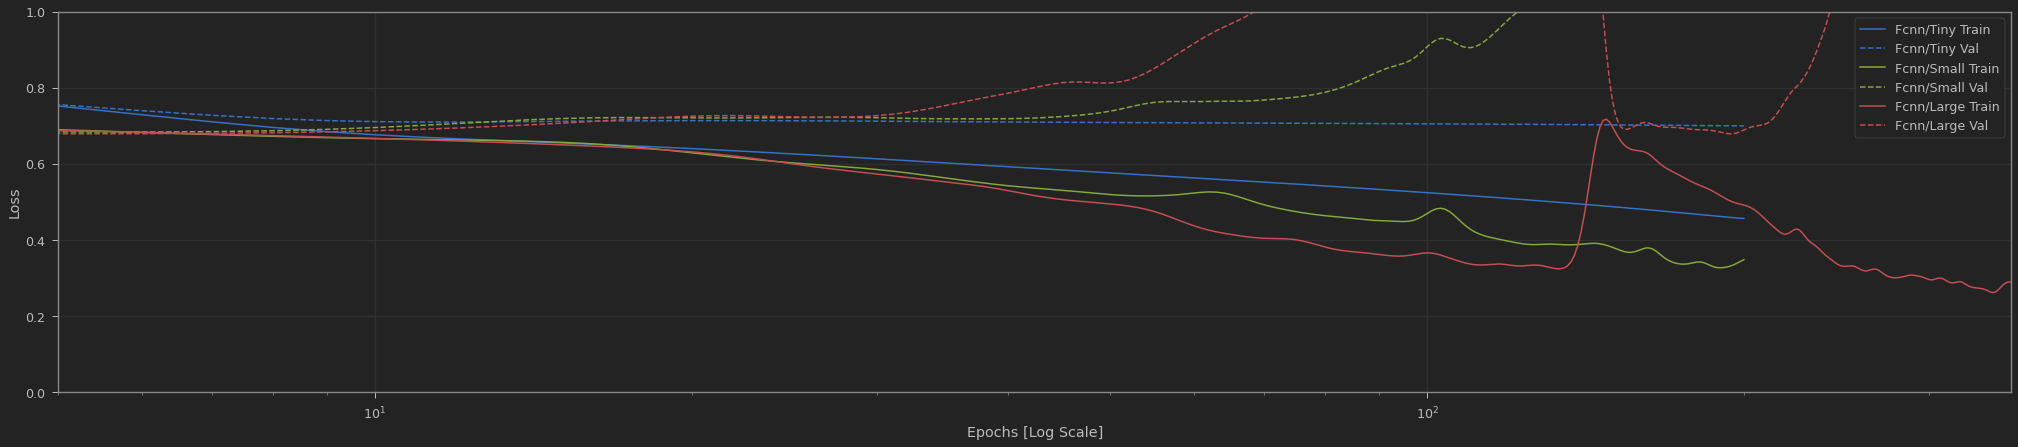

In [15]:
plotter_loss.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.0, 1.])
plt.xlabel("Epochs [Log Scale]")

### Dropout

Although we got an accuracy of 0.75 looking at loss function chart is pretty obvious: There is overfiting. Now we have an overfitted NN let's make some adjustments to improve generalization capacity startin from dropout techniques.  

In [16]:
tiny_dropout = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
size_histories['fcnn/tiny/dropout'] = compile_and_fit(tiny_dropout, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/tiny/dropout", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATIO######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(size_histories['fcnn/tiny/dropout'].history["accuracy"]))
print('test acc:', max(size_histories['fcnn/tiny/dropout'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9

(0.0, 1.5)

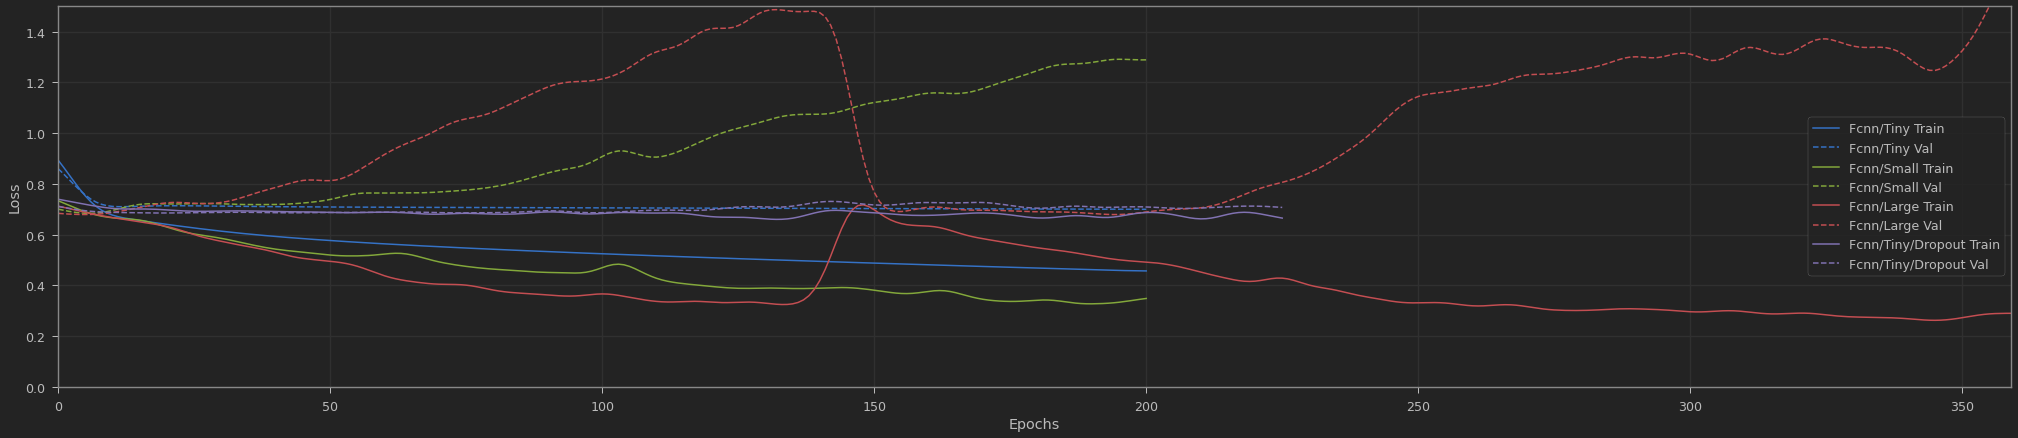

In [17]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0., 1.5])

(0.0, 1.1)

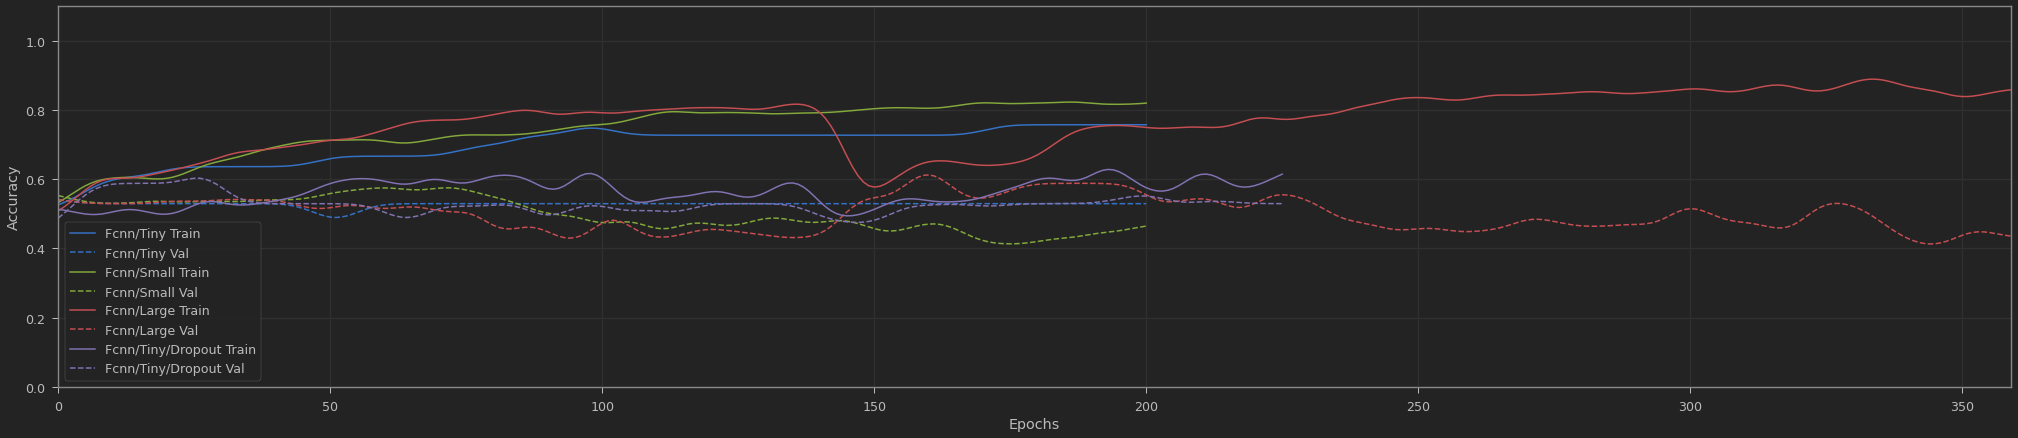

In [18]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
plt.ylim([0., 1.1])

Validation accuracy keeps improving more epoch with a total improvement from 0.75 to 0.81. Furthemore, the gap between training loss function and test loss function has been reduced.

### Kernel regularizer

In [19]:
# shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
# shutil.copytree(logdir/'fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['large'] = size_histories['fcnn/large']
regularizer_histories['dropout'] = size_histories['fcnn/tiny/dropout']

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

L1 regularization, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

L2 regularization, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In tf.keras, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [20]:
l2_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
regularizer_histories['l2'] = compile_and_fit(l2_model, train_dataset, 
                                              test_dataset, 
                                              optimizer=tf.keras.optimizers.Adam(lr),
                                              name="regularizers/l2")
# Evaluate the model on the test data using `evaluate`
print("\n#######################EVALUATIO######################")
print('test acc:', max(regularizer_histories['l2'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['l2'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 200       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 268,137
Trainable params: 268,137
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4545,  loss:1.2915,  val_accuracy:0.5882,  val_loss:1.1913,  
................................

(0.0, 0.9)

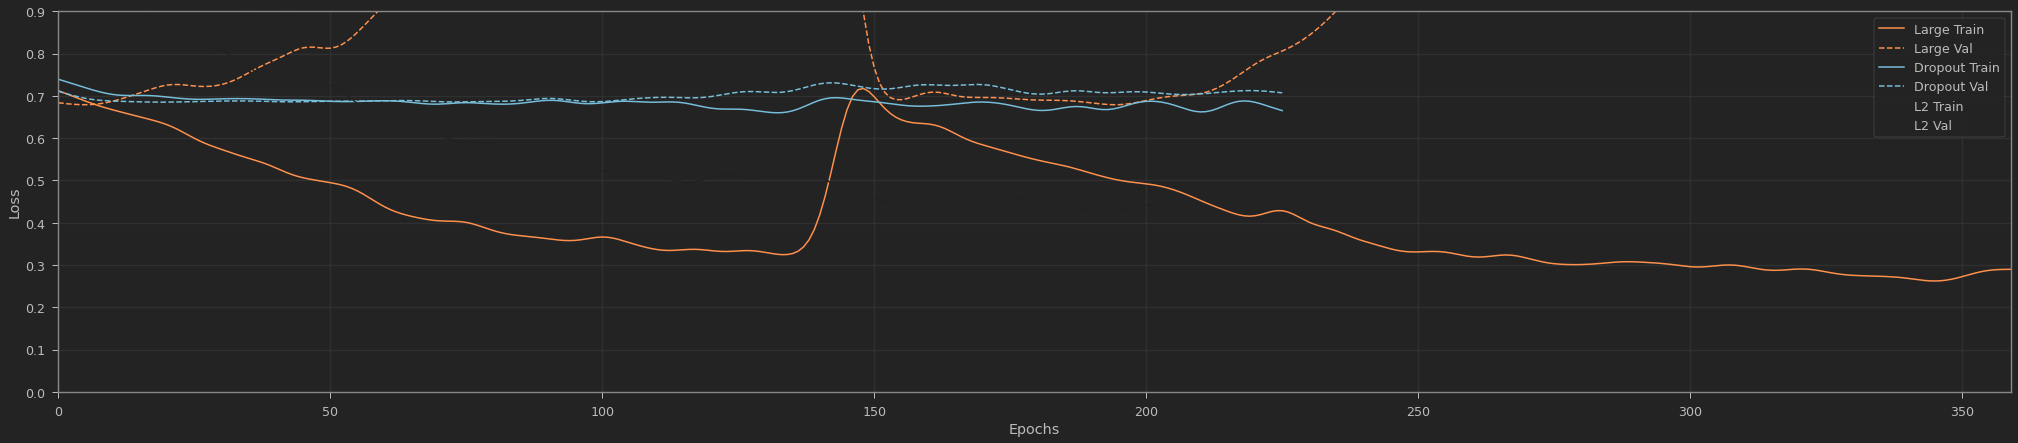

In [21]:
plotter_loss.plot(regularizer_histories)
plt.ylim([0., 0.9])

(0.1, 1.0)

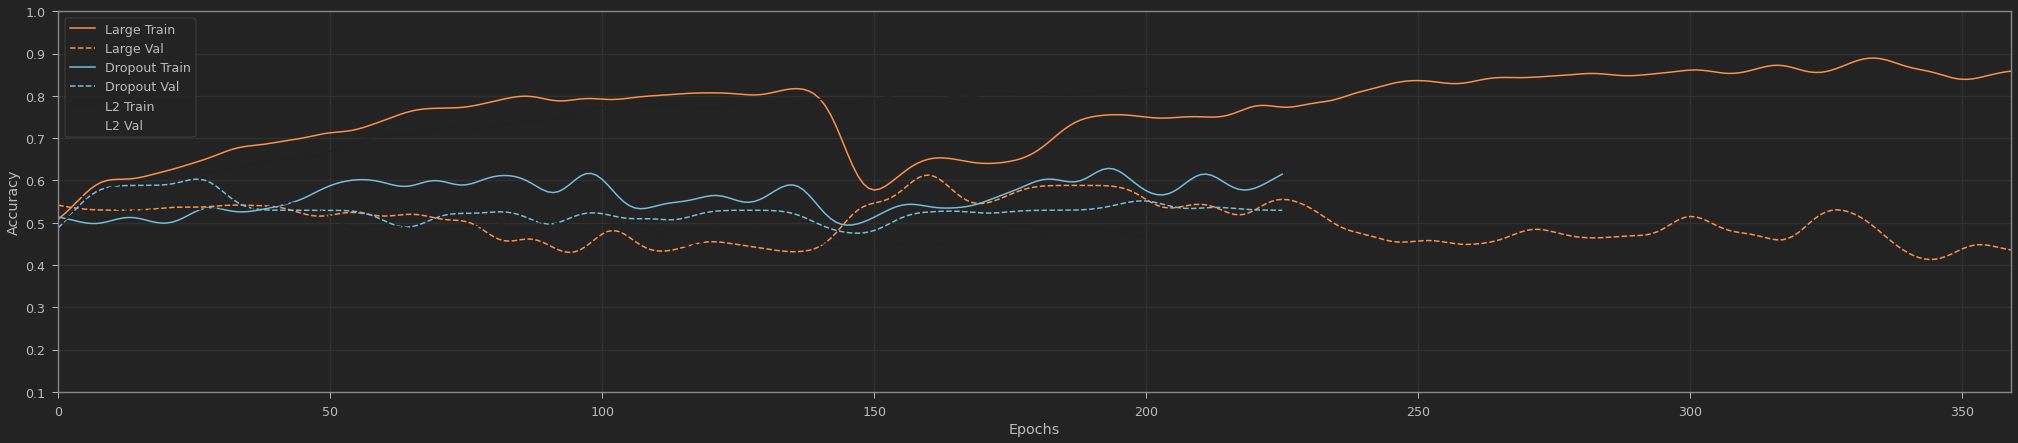

In [22]:
plotter_acc.plot(regularizer_histories)
plt.ylim([0.1, 1.])

Now let's see what happens combining both techniques

In [23]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1),
                 input_shape=(num_features,)),
    layers.Dense(main_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(secondary_units, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    layers.Dense(last_unit, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l1(lr1)),
    tf.keras.layers.Dropout(dr),
    layers.Dense(num_classes, activation=tf.nn.sigmoid)
])

tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
regularizer_histories['combined'] = compile_and_fit(combined_model, train_dataset, test_dataset, "regularizers/combined",
                                                   optimizer=get_optimizer())

# Evaluate the model on the test data using `evaluate`
print()
print('test acc:', max(regularizer_histories['combined'].history["val_accuracy"]))
print('train acc:', max(regularizer_histories['combined'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 200       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 268,137
Trainable params: 268,137
Non-trainable params: 0
__________________________________________________

(5.0, 359.0)

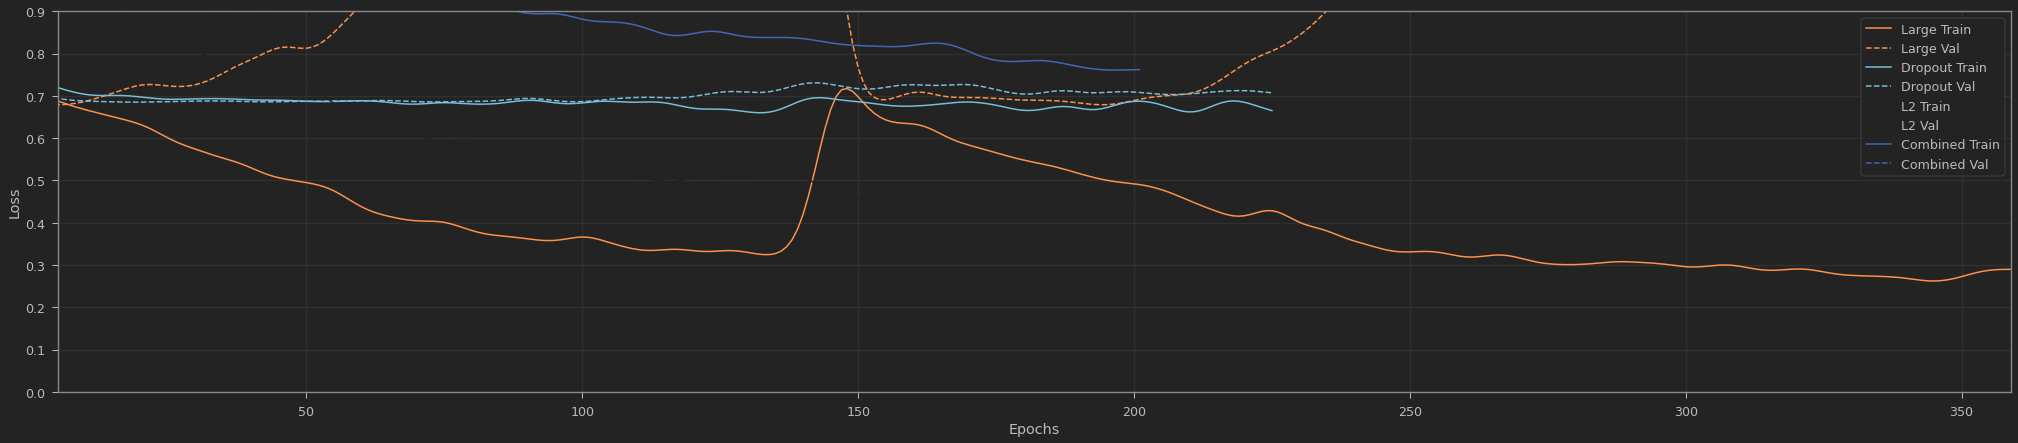

In [24]:
plotter_loss.plot(regularizer_histories)
plt.ylim([0., 0.9])
plt.xlim([5, max(plt.xlim())])

(0.4, 1.2)

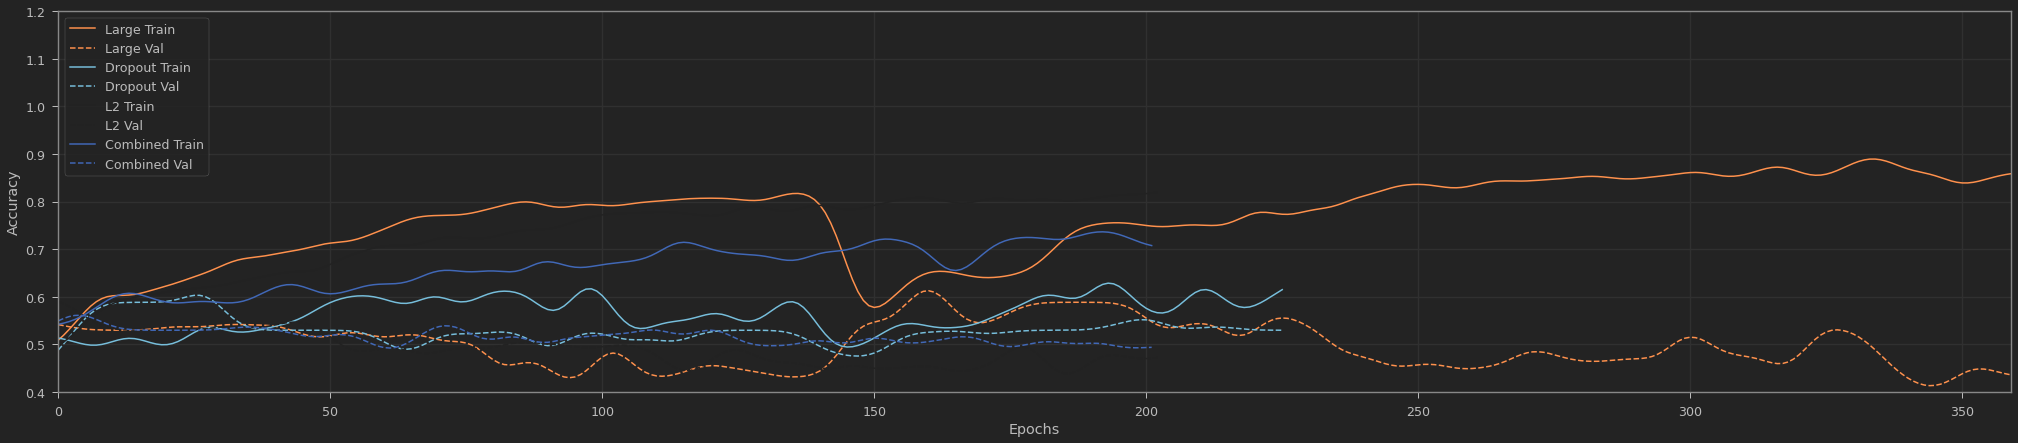

In [25]:
plotter_acc.plot(regularizer_histories)
plt.ylim([0.4, 1.2])

## Batch Normalization

Batch normalization (also known as batch norm) is a method used to make artificial neural networks faster and more stable through normalization of the input layer by re-centering and re-scaling. It was proposed by Sergey Ioffe and Christian Szegedy in 2015.

[Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

[Tensorflow implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)


In [26]:
batch_histories = {}
batch_histories['large'] = size_histories['fcnn/large']
batch_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [27]:
small_batch = tf.keras.Sequential([
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
batch_histories['fcnn/small/batch'] = compile_and_fit(small_batch, 
                                                      train_dataset,
                                                      test_dataset,
                                                      "fcnn/small/batch", 
                                                      optimizer=tf.keras.optimizers.Adam(lr), 
                                                      max_epochs=num_epochs)

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(batch_histories['fcnn/small/batch'].history["accuracy"]))
print('test acc:', max(batch_histories['fcnn/small/batch'].history["val_accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                262208    
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                1560      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24)                96        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2

(5.0, 359.0)

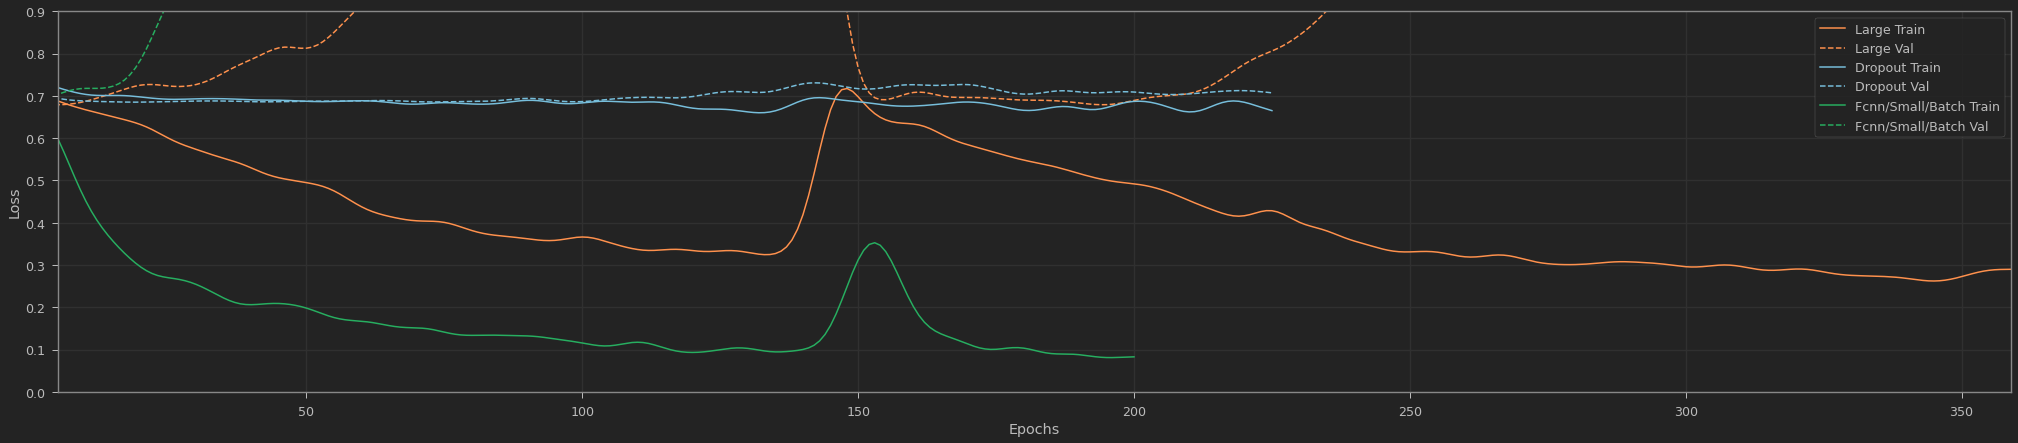

In [28]:
plotter_loss.plot(batch_histories)
plt.ylim([0., 0.9])
plt.xlim([5, max(plt.xlim())])

## LSTM-FCNN

Univariate time series classification model, the Long Short Term Memory Fully Convolutional Network (LSTM-FCN) to capture time related information

In [29]:
lstm_histories = {}
lstm_histories['large'] = size_histories['fcnn/large']
lstm_histories['dropout'] = size_histories['fcnn/tiny/dropout']

In [30]:
lstm_units=24
lstm_tiny_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)
                        ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/tiny'] = compile_and_fit(lstm_tiny_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/tiny")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('test acc:', max(lstm_histories['lstm/tiny'].history["val_accuracy"]))
print('train acc:', max(lstm_histories['lstm/tiny'].history["accuracy"]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 4096)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 24)                395616    
_________________________________________________________________
batch_normalization (BatchNo (None, 24)                96        
_________________________________________________________________
dense (Dense)                (None, 8)                 200       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 395,921
Trainable params: 395,873
Non-trainable params: 48
_________________________________________________________________

Epoch: 0, accuracy:0.5152,  loss:0.8872,  val_accuracy:0.5882,  val_loss:0.8515,  
...............................

In [31]:
lstm_small_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/small'] = compile_and_fit(lstm_small_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                                        lr=1e-4,
#                                                                        multiplier=10),
                                               name="lstm/small")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/small'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/small'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 4096)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 24)             395616    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 24)             96        
_________________________________________________________________
lstm_1 (LSTM)                (None, 24)                4704      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24)                96        
_________________________________________________________________
dense (Dense)                (None, 8)                 200       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0

In [32]:
lstm_units=64
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_large_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),# expand the dimension form (50, 4096) to (50, 4096, 1)
                      input_shape=[num_features,]),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=True,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(lstm_units, activation=tf.nn.tanh, return_sequences=False,
                        kernel_regularizer=regularizers.l2(lr2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu, input_shape=(num_features,)), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(main_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(secondary_units, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(last_unit, activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dr),
    tf.keras.layers.Dense(num_classes, activation=tf.nn.sigmoid)
])
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
lstm_histories['lstm/large'] = compile_and_fit(lstm_large_model, 
                                               train_dataset, 
                                               test_dataset, 
                                               optimizer=tf.keras.optimizers.Adam(lr), 
#                                                optimizer=get_optimizer(int(round(size/mini_batch_size)),
#                                                lr=1e-4,
#                                                multiplier=10), 
                                                name="lstm/large")

print("\n#######################EVALUATION######################")
# Evaluate the model on the test data using `evaluate`
print('train acc:', max(lstm_histories['lstm/large'].history["accuracy"]))
print('test acc:', max(lstm_histories['lstm/large'].history["val_accuracy"]))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 4096)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 64)             1065216   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 64)             256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                2

(5.0, 359.0)

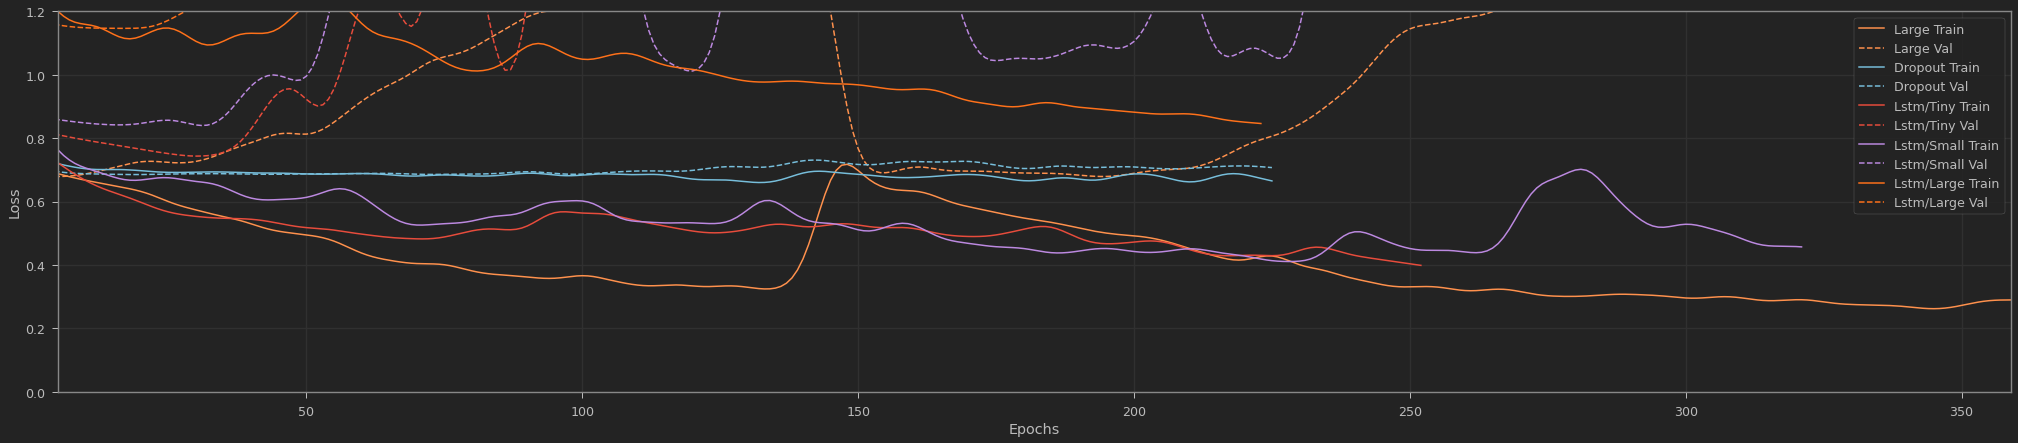

In [33]:
plotter_loss.plot(lstm_histories, "loss")
plt.ylim([0., 1.2])
plt.xlim([5, max(plt.xlim())])

(5.0, 359.0)

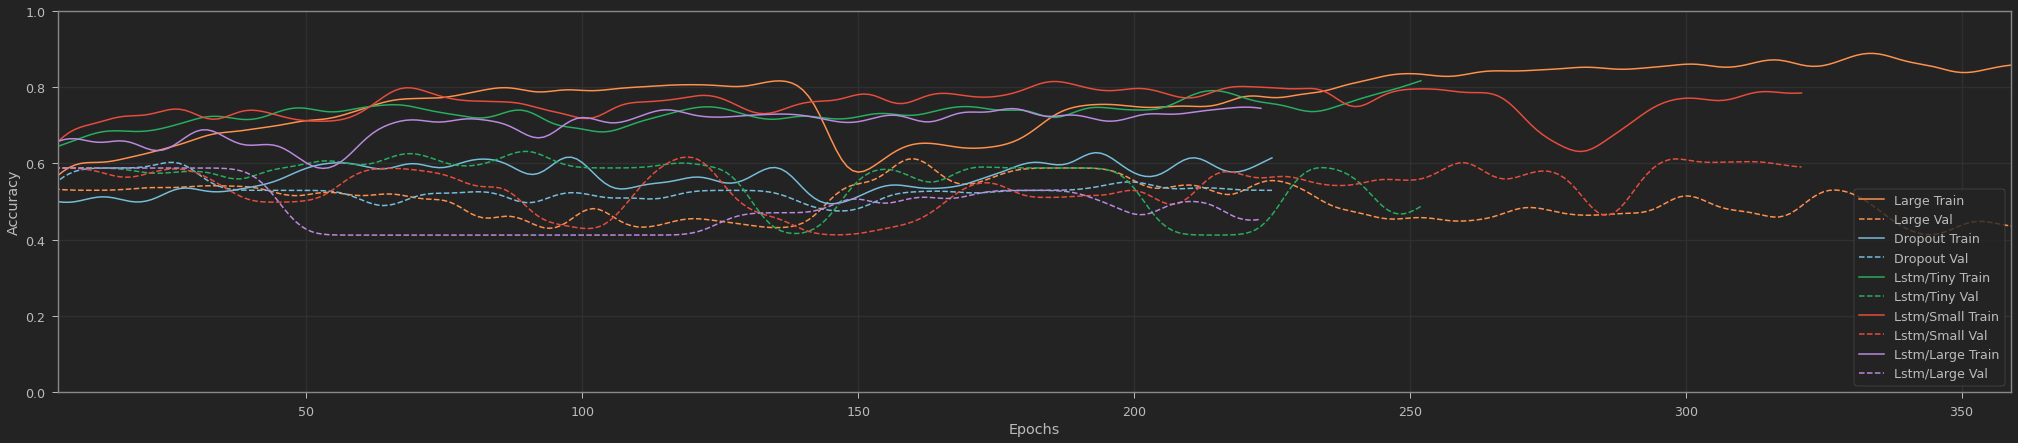

In [34]:
plotter_acc.plot(lstm_histories)
plt.ylim([0., 1.])
plt.xlim([5, max(plt.xlim())])